In [ ]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd


# -------------------------
# Core: SD1/SD2 + CSI/ModCSI
# -------------------------
def _sd1_sd2_from_rr_ms(rr_ms_window: np.ndarray) -> tuple[float, float]:
    rr = rr_ms_window.astype(float)
    x = rr[:-1]
    y = rr[1:]
    d = y - x
    s = y + x
    sd1 = np.std(d, ddof=1) / np.sqrt(2.0)
    sd2 = np.std(s, ddof=1) / np.sqrt(2.0)
    return float(sd1), float(sd2)


def compute_csi_modcsi_sliding(rr_s: np.ndarray, win_rr: int = 100) -> pd.DataFrame:
    """
    Sliding windows -> SD1/SD2 -> CSI + Modified CSI.
    CSI = SD2/SD1
    ModCSI (NeuroKit-style "modified CSI") = (4*SD2)^2 / (4*SD1) = 4*SD2^2 / SD1
    """
    rr_s = np.asarray(rr_s, dtype=float)
    rr_s = rr_s[np.isfinite(rr_s)]
    rr_ms = rr_s * 1000.0
    if rr_ms.size < win_rr:
        return pd.DataFrame()

    W = np.lib.stride_tricks.sliding_window_view(rr_ms, window_shape=win_rr)
    n = W.shape[0]

    sd1 = np.empty(n, dtype=float)
    sd2 = np.empty(n, dtype=float)

    for i in range(n):
        sd1[i], sd2[i] = _sd1_sd2_from_rr_ms(W[i])

    csi = sd2 / np.maximum(sd1, 1e-12)
    modcsi = (4.0 * (sd2 ** 2)) / np.maximum(sd1, 1e-12)

    return pd.DataFrame({
        "sd1_ms": sd1,
        "sd2_ms": sd2,
        "csi": csi,
        "modcsi": modcsi,
    })


# -------------------------
# Comparison helpers
# -------------------------
def _corr(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    ok = np.isfinite(a) & np.isfinite(b)
    if ok.sum() < 3:
        return np.nan
    return float(np.corrcoef(a[ok], b[ok])[0, 1])


def summarize_pair(df_a: pd.DataFrame, df_b: pd.DataFrame, *, label_a: str, label_b: str) -> pd.DataFrame:
    """
    df_a and df_b must have columns: csi, modcsi
    """
    n = min(len(df_a), len(df_b))
    if n == 0:
        return pd.DataFrame([{
            "pair": f"{label_a} vs {label_b}",
            "n_windows": 0,
            "corr_csi": np.nan,
            "corr_modcsi": np.nan,
            "p99_modcsi_a": np.nan,
            "p99_modcsi_b": np.nan,
            "median_absdiff_csi": np.nan,
            "median_absdiff_modcsi": np.nan,
        }])

    a_csi = df_a["csi"].to_numpy()[:n]
    b_csi = df_b["csi"].to_numpy()[:n]
    a_mod = df_a["modcsi"].to_numpy()[:n]
    b_mod = df_b["modcsi"].to_numpy()[:n]

    return pd.DataFrame([{
        "pair": f"{label_a} vs {label_b}",
        "n_windows": int(n),
        "corr_csi": _corr(a_csi, b_csi),
        "corr_modcsi": _corr(a_mod, b_mod),
        "p99_modcsi_a": float(np.nanpercentile(a_mod, 99)),
        "p99_modcsi_b": float(np.nanpercentile(b_mod, 99)),
        "median_absdiff_csi": float(np.nanmedian(np.abs(a_csi - b_csi))),
        "median_absdiff_modcsi": float(np.nanmedian(np.abs(a_mod - b_mod))),
    }])


def run_neurokit_validation_on_file(
    csv_path: Path,
    *,
    win_rr: int = 100,
    col_lab: str = "RR_labview_s",
    col_nk: str = "RR_python_s",
) -> dict:
    df = pd.read_csv(csv_path)

    rr_lab = pd.to_numeric(df[col_lab], errors="coerce").dropna().to_numpy()
    rr_nk  = pd.to_numeric(df[col_nk], errors="coerce").dropna().to_numpy()

    # "ours" formula (SD1/SD2-based) on both RR sources
    feat_lab = compute_csi_modcsi_sliding(rr_lab, win_rr=win_rr)
    feat_nk  = compute_csi_modcsi_sliding(rr_nk,  win_rr=win_rr)

    # Compare the derived CSI/ModCSI between RR sources
    summary = summarize_pair(feat_lab, feat_nk, label_a="LabVIEW RR", label_b="NeuroKit RR")

    return {
        "csv_path": str(csv_path),
        "rr_lab_len": int(len(rr_lab)),
        "rr_nk_len": int(len(rr_nk)),
        "feat_lab": feat_lab,
        "feat_nk": feat_nk,
        "summary": summary,
    }



In [2]:
from pathlib import Path

p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")

out = run_neurokit_validation_on_file(p, win_rr=100)

print("RR lengths:", out["rr_lab_len"], out["rr_nk_len"])
print(out["summary"])


RR lengths: 226444 226444
                        pair  n_windows  corr_csi  corr_modcsi  p99_modcsi_a  \
0  LabVIEW RR vs NeuroKit RR     226345  0.878199     0.955899   7073.447901   

   p99_modcsi_b  median_absdiff_csi  median_absdiff_modcsi  
0   6869.698674            0.040695               7.552154  


In [3]:
df = pd.read_csv(p)
print(df["RR_labview_s"].median(), df["RR_python_s"].median())


0.8491158485412598 0.849609375


In [4]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd


def rr_median_filter_7(rr_s: np.ndarray) -> np.ndarray:
    """7-beat median filter of RR tachogram. Same length as input."""
    rr = np.asarray(rr_s, dtype=float)
    n = rr.size
    if n < 7:
        return rr.copy()
    out = np.empty(n, dtype=float)
    # pad by edge values (simple + stable)
    pad = 3
    rr_pad = np.r_[np.full(pad, rr[0]), rr, np.full(pad, rr[-1])]
    for i in range(n):
        out[i] = np.median(rr_pad[i:i+7])
    return out


def sliding_windows_rr(rr_s: np.ndarray, win_rr: int) -> np.ndarray:
    rr_s = np.asarray(rr_s, dtype=float)
    return np.lib.stride_tricks.sliding_window_view(rr_s, window_shape=win_rr)


def poincare_sd1_sd2(rr_ms_win: np.ndarray) -> tuple[float, float]:
    rr = rr_ms_win.astype(float)
    x = rr[:-1]
    y = rr[1:]
    d = y - x
    s = y + x
    sd1 = np.std(d, ddof=1) / np.sqrt(2.0)
    sd2 = np.std(s, ddof=1) / np.sqrt(2.0)
    return float(sd1), float(sd2)


def csi_from_sd(sd1: np.ndarray, sd2: np.ndarray) -> np.ndarray:
    return sd2 / np.maximum(sd1, 1e-12)  # (4*SD2)/(4*SD1) cancels


def modcsi_modified_from_sd(sd1: np.ndarray, sd2: np.ndarray) -> np.ndarray:
    # Jeppesen/NeuroKit "CSI_Modified": (4*SD2)^2 / (4*SD1) = 4*SD2^2 / SD1
    return (4.0 * (sd2 ** 2)) / np.maximum(sd1, 1e-12)


def slope_hr_least_squares(rr_s_win: np.ndarray) -> float:
    """
    Least squares slope of HR (BPM) vs time (seconds) within a RR window.
    Time axis: cumulative RR from window start (beat-end times).
    HR: 60 / RR_s (BPM). Uses window RR (already median-filtered if desired).
    """
    rr = np.asarray(rr_s_win, dtype=float)
    if rr.size < 3:
        return np.nan
    t = np.cumsum(rr)  # seconds, increasing
    hr = 60.0 / np.maximum(rr, 1e-12)

    # linear regression slope = cov(t, hr) / var(t)
    t0 = t - t.mean()
    h0 = hr - hr.mean()
    denom = np.dot(t0, t0)
    if denom <= 0:
        return np.nan
    slope = np.dot(t0, h0) / denom  # BPM per second
    return float(abs(slope))        # Jeppesen: absolute value


def compute_jeppesen_features(rr_s: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    """
    Returns per-window features aligned to window END time:
      - t_end_s (relative, seconds since start)
      - CSI100 (unfiltered RR)
      - ModCSI100 (7RR-median-filtered RR)
      - SlopeHR100 (LS slope on HR vs time, on filtered RR)
      - products
    """
    rr_s = pd.to_numeric(pd.Series(rr_s), errors="coerce").dropna().to_numpy(dtype=float)
    if rr_s.size < win_rr:
        return pd.DataFrame()

    rr_filt = rr_median_filter_7(rr_s)

    # windows
    W_raw  = sliding_windows_rr(rr_s, win_rr)
    W_filt = sliding_windows_rr(rr_filt, win_rr)

    n = W_raw.shape[0]

    sd1_raw = np.empty(n, dtype=float)
    sd2_raw = np.empty(n, dtype=float)
    sd1_f   = np.empty(n, dtype=float)
    sd2_f   = np.empty(n, dtype=float)
    slopeHR = np.empty(n, dtype=float)

    for i in range(n):
        sd1_raw[i], sd2_raw[i] = poincare_sd1_sd2(W_raw[i] * 1000.0)
        sd1_f[i],   sd2_f[i]   = poincare_sd1_sd2(W_filt[i] * 1000.0)
        slopeHR[i] = slope_hr_least_squares(W_filt[i])

    csi = csi_from_sd(sd1_raw, sd2_raw)                 # unfiltered
    modcsi = modcsi_modified_from_sd(sd1_f, sd2_f)      # filtered RR
    # time at END of window:
    t_end_s = np.cumsum(rr_s)[win_rr-1:]

    df = pd.DataFrame({
        "t_end_s": t_end_s,
        "CSI100": csi,
        "ModCSI100_filt": modcsi,
        "SlopeHR100": slopeHR,
    })
    df["CSI100_x_SlopeHR"] = df["CSI100"] * df["SlopeHR100"]
    df["ModCSI100filt_x_SlopeHR"] = df["ModCSI100_filt"] * df["SlopeHR100"]
    return df


def auto_thresholds_from_series(df_feat: pd.DataFrame, value_col: str, *,
                                factor: float = 1.05,
                                first_12h_s: float = 12*3600,
                                first_24h_s: float = 24*3600) -> pd.DataFrame:
    """
    Compute 1.05 * max(value) in:
      - first 12h
      - first 24h
      - first half of available time
    """
    if df_feat.empty:
        return pd.DataFrame()

    t = df_feat["t_end_s"].to_numpy(dtype=float)
    v = df_feat[value_col].to_numpy(dtype=float)

    t_max = float(np.nanmax(t))
    half = 0.5 * t_max

    def seg(name: str, t0: float, t1: float):
        m = (t >= t0) & (t <= t1) & np.isfinite(v)
        mx = float(np.nanmax(v[m])) if np.any(m) else np.nan
        return dict(mode=name, seg_start_s=t0, seg_end_s=t1, max_value=mx, factor=factor,
                    threshold=(factor*mx if np.isfinite(mx) else np.nan))

    rows = [
        seg("first_12h", 0.0, min(first_12h_s, t_max)),
        seg("first_24h", 0.0, min(first_24h_s, t_max)),
        seg("first_half", 0.0, half),
    ]
    return pd.DataFrame(rows)


def run_file_ab_test(csv_path: Path, *, win_rr: int = 100) -> dict:
    df = pd.read_csv(csv_path)
    rr_lab = df["RR_labview_s"].to_numpy()
    rr_nk  = df["RR_python_s"].to_numpy()

    feat_lab = compute_jeppesen_features(rr_lab, win_rr=win_rr)
    feat_nk  = compute_jeppesen_features(rr_nk,  win_rr=win_rr)

    # thresholds for both products + raw CSI/ModCSI if you want
    tabs = []
    for label, feat in [("LabVIEW_RR", feat_lab), ("NeuroKit_RR", feat_nk)]:
        for col in ["CSI100", "ModCSI100_filt", "SlopeHR100", "CSI100_x_SlopeHR", "ModCSI100filt_x_SlopeHR"]:
            tab = auto_thresholds_from_series(feat, col, factor=1.05)
            tab.insert(0, "RR_source", label)
            tab.insert(1, "value_col", col)
            tabs.append(tab)

    thr_table = pd.concat(tabs, ignore_index=True) if tabs else pd.DataFrame()

    return {"feat_lab": feat_lab, "feat_nk": feat_nk, "thresholds": thr_table}


In [5]:
p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")
out = run_file_ab_test(p, win_rr=100)

print("Threshold table (head):")
display(out["thresholds"].head(30))

# Hvis du vil gemme:
out["thresholds"].to_csv(r"E:\Speciale - Results\study5_out\threshold_compare_P01_R01.csv", index=False)


Threshold table (head):


,RR_source,value_col,mode,seg_start_s,seg_end_s,max_value,factor,threshold
0,LabVIEW_RR,CSI100,first_12h,0.0,43200.000000,16.545954,1.05,17.373251
1,LabVIEW_RR,CSI100,first_24h,0.0,86400.000000,24.636410,1.05,25.868230
2,LabVIEW_RR,CSI100,first_half,0.0,95206.103520,24.636410,1.05,25.868230
3,LabVIEW_RR,ModCSI100_filt,first_12h,0.0,43200.000000,15410.475785,1.05,16180.999575
4,LabVIEW_RR,ModCSI100_filt,first_24h,0.0,86400.000000,21934.320854,1.05,23031.036897
5,LabVIEW_RR,ModCSI100_filt,first_half,0.0,95206.103520,21934.320854,1.05,23031.036897
6,LabVIEW_RR,SlopeHR100,first_12h,0.0,43200.000000,0.451150,1.05,0.473707
7,LabVIEW_RR,SlopeHR100,first_24h,0.0,86400.000000,0.939220,1.05,0.986181
8,LabVIEW_RR,SlopeHR100,first_half,0.0,95206.103520,0.939220,1.05,0.986181
9,LabVIEW_RR,CSI100_x_SlopeHR,first_12h,0.0,43200.000000,7.431307,1.05,7.802872


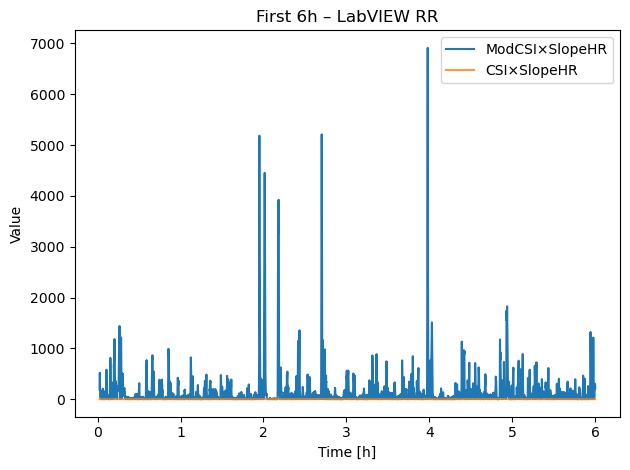

In [6]:
import matplotlib.pyplot as plt

feat = out["feat_lab"]  # eller feat_nk
mask = feat["t_end_s"] <= 6*3600

plt.figure()
plt.plot(feat.loc[mask, "t_end_s"]/3600, feat.loc[mask, "ModCSI100filt_x_SlopeHR"], label="ModCSI×SlopeHR")
plt.plot(feat.loc[mask, "t_end_s"]/3600, feat.loc[mask, "CSI100_x_SlopeHR"], label="CSI×SlopeHR", alpha=0.8)
plt.xlabel("Time [h]")
plt.ylabel("Value")
plt.title("First 6h – LabVIEW RR")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def plot_around_interval(feat: pd.DataFrame, t0: float, t1: float, pad_s: float = 30*60):
    import matplotlib.pyplot as plt
    a = max(0.0, t0 - pad_s)
    b = t1 + pad_s
    m = (feat["t_end_s"] >= a) & (feat["t_end_s"] <= b)

    plt.figure()
    plt.plot(feat.loc[m, "t_end_s"]/60, feat.loc[m, "ModCSI100filt_x_SlopeHR"], label="ModCSI×SlopeHR")
    plt.plot(feat.loc[m, "t_end_s"]/60, feat.loc[m, "CSI100_x_SlopeHR"], label="CSI×SlopeHR", alpha=0.8)
    plt.axvspan(t0/60, t1/60, alpha=0.2, label="Seizure interval")
    plt.xlabel("Time [min]")
    plt.ylabel("Value")
    plt.title("Around seizure")
    plt.legend()
    plt.tight_layout()
    plt.show()
